In [1]:
"""
Alexey Yushkin
April 15, 2021
Notes: The script's running time is several minutes. To check the script not wasting much time  
       decrease N_SIMULATIONS in the cell #6.
       The intermediate results after the cost optimization functions are used for demonstration purposes only 
       and do not consider changes in exchange rates and metals' prices. 
""";

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
from pulp import *
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime as dt, timedelta
import re
# import json
# from requests import Session
# from requests.exceptions import ConnectionError, Timeout, TooManyRedirects

In [3]:
# Deactivating warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Setting pandas output option
pd.options.display.max_columns = 50
pd.options.display.max_rows = 250

In [5]:
# By default, take into account the current balance of components and materials in the warehouse
# and times of delivery
take_balance = True

In [6]:
# If necessary, change the number of simulations.
# If there is no intention to simulate currency exchange rates and metals prices fluctuations,
# change the variable value to 1. 
N_SIMULATIONS = 100

In [7]:
# By default, orders are placed each 30 days, to change order frequency input the number of days 
# between moments of placing orders 
period = 30

In [8]:
# By default, changes of currency excahnge rates and metals' prices are analysed for previous 365 days
analyze_days = 365

# If no simulation conducted, standard deviations must be equal to 0, so no need in historical data
# to be analyzed 
if not N_SIMULATIONS - 1:
    analyze_days = 0

# USD/RUR rate at the moment the dataset was compiled 
USD_RATE = 73.66

# Upper bound of current USD range where prices in RUR do not change
USD_UPPER_CURRENT = 80

# Upper bound of the next USD range in case the exchange rate raises higher than USD_UPPER_CURRENT
USD_UPPER_NEXT = 90

# EUR/RUR rate at the moment the dataset was compiled 
EUR_RATE = 88.12

In [9]:
## Setting initial data
# Interest rate, %
INT_RATE = 16

# Amount of money available for borrowing from a bank, RUR
AVAIL_FUNDS = 3400000

# Space in warehouse available for storage, m3
AVAIL_STOR_SPACE = 30

In [10]:
# Inflation rate, %
INF_RATE = 4.9

In [11]:
# Calculating cost of capital per day
CAP_COST_DAY = (INT_RATE + INF_RATE) / 100 / 365

In [12]:
# Reading data from the file
raw_data = pd.read_excel("PartsAndProducts.xls", sheet_name="Data", skiprows=1, header=0, nrows=162)

In [13]:
# Creating a list of final products
products_lst = list(raw_data.columns[1:12])

In [14]:
# Creating a list of intermediate products
assemblies_lst = list(raw_data.columns[13:17])

In [15]:
# Creating a data frame of components and products
parts_and_prods = raw_data.drop(["Unnamed: 12", "Unnamed: 17", "Unnamed: 19", "Unnamed: 21", "Note"], 
                                axis=1).loc[:158, :]

In [16]:
# Replacing NaNs in components demand with 0
parts_and_prods.fillna(0, inplace=True)

In [17]:
# Creating a series of annual demand for each final product
products_demand = raw_data.filter(items=products_lst).iloc[160, :]

In [18]:
# Creating a series of spikes in demand for each final product
products_demand_spike = raw_data.filter(items=products_lst).iloc[161, :]

In [19]:
# Calculating demand for intermediate products
pcb_esg_demand = (np.dot(parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESG assembled", 
                                             products_lst], products_demand)).astype(int)[0] \
                 + parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESG assembled", 
                                       "Demand as spare parts"].astype(int).iloc[0]

pcb_esn_demand = (np.dot(parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESNv4 assembled", 
                                             products_lst], products_demand)).astype(int)[0] \
                 + parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESNv4 assembled", 
                                       "Demand as spare parts"].astype(int).iloc[0]

pcb_eso_demand = (np.dot(parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESO2 assembled", 
                                             products_lst], products_demand)).astype(int)[0] \
                 + parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESO2 assembled", 
                                       "Demand as spare parts"].astype(int).iloc[0]

pcb_esv_demand = (np.dot(parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESV51AMR1 assembled", 
                                             products_lst], products_demand)).astype(int)[0] \
                 + parts_and_prods.loc[parts_and_prods["Component/Material"] == "PCB ESV51AMR1 assembled", 
                                       "Demand as spare parts"].astype(int).iloc[0]

In [20]:
# Creating a series of annual demand for each intermediate product
assemblies_demand = pd.Series([pcb_esg_demand, pcb_esn_demand, pcb_eso_demand, pcb_esv_demand], 
                              index=assemblies_lst)

In [21]:
# Creating a column for components used in final products 
parts_and_prods["demand_in_products"] = np.dot(parts_and_prods.loc[:, products_lst], products_demand)

In [22]:
# Creating a column for components used in intermediate products 
parts_and_prods["demand_in_assemblies"] = np.dot(parts_and_prods.loc[:, assemblies_lst], assemblies_demand)

In [23]:
# Creating a column for total numbers of components
parts_and_prods["total_annual_demand"] = parts_and_prods["Demand as spare parts"] \
                                         + parts_and_prods["demand_in_products"] \
                                         + parts_and_prods["demand_in_assemblies"]

In [24]:
# Removing rows with assembleys as components, which are not needed any more
for assembly in assemblies_lst:
    
    parts_and_prods.drop(parts_and_prods[parts_and_prods["Component/Material"] \
                                         == assembly].index, axis=0, inplace=True)

In [25]:
# Resetting indexes
parts_and_prods.reset_index(drop=True, inplace=True)

In [26]:
# Type transformation from object to integer
parts_and_prods["Time of delivery, days"] = parts_and_prods["Time of delivery, days"].astype(int)

In [27]:
# Calculating the reserve for spikes in final products demand taking into account if:
# - a component is used in less than half of final products and
# - its time of delivery is more than 5 days
parts_and_prods["reserve_for_spikes_in_demand"] = \
    (np.dot(parts_and_prods.loc[:, products_lst], products_demand_spike)) \
    * ((parts_and_prods.loc[:, products_lst] != 0).sum(axis=1) < (len(products_lst) / 2)) \
    * (parts_and_prods.loc[:, "Time of delivery, days"] > 5)

In [28]:
# Replacing missing space in warehouse values with zeros
parts_and_prods["Space in warehouse"] = \
    parts_and_prods["Space in warehouse"].apply(lambda x: x if x != "-" else 0)

In [29]:
# Replacing missing quantities and prices with values of previous quantites and prices pairs
for i in range(len(parts_and_prods)):
    
    if parts_and_prods.loc[i, "Qty 2"] == "-": 
        
        parts_and_prods.loc[i, "Qty 2"] = parts_and_prods.loc[i, "MOQ"]
        
        parts_and_prods.loc[i, "Price 2, RUR"] = parts_and_prods.loc[i, "Price MOQ, RUR"]
        
        
    if parts_and_prods.loc[i, "Qty 3"] == "-": 
        
        parts_and_prods.loc[i, "Qty 3"] = parts_and_prods.loc[i, "Qty 2"]
        
        parts_and_prods.loc[i, "Price 3, RUR"] = parts_and_prods.loc[i, "Price 2, RUR"]

In [30]:
# Type transformations from objects to integers and floats
parts_and_prods["Current balance in warehouse"] = parts_and_prods["Current balance in warehouse"].astype(float)

parts_and_prods["MOQ"] = parts_and_prods["MOQ"].astype(int)

parts_and_prods["Price MOQ, RUR"] = parts_and_prods["Price MOQ, RUR"].astype(float)

parts_and_prods["Qty 2"] = parts_and_prods["Qty 2"].astype(int)

parts_and_prods["Price 2, RUR"] = parts_and_prods["Price 2, RUR"].astype(float)

parts_and_prods["Qty 3"] = parts_and_prods["Qty 3"].astype(int)

parts_and_prods["Price 3, RUR"] = parts_and_prods["Price 3, RUR"].astype(float)

parts_and_prods["Batch"] = parts_and_prods["Batch"].astype(int)

parts_and_prods["Cost per order, RUR"] = parts_and_prods["Cost per order, RUR"].astype(float)

In [31]:
# Calculating an average demand per day
parts_and_prods["avg_demand_day"] = parts_and_prods["total_annual_demand"] / 365

In [32]:
# Calculating a demand per peiod as an average demand per day times quantity of days between orders 
# plus reserve for spikes in demand
parts_and_prods["demand_period"] = parts_and_prods["avg_demand_day"] * period \
                                   + parts_and_prods["reserve_for_spikes_in_demand"]

In [33]:
# Adding columns for current demand and minimum quantity as highest value among MOQ and demand
for i in range(len(parts_and_prods)):
    
    parts_and_prods.loc[i, "current_demand"] = parts_and_prods.loc[i, "demand_period"] \
                                               + parts_and_prods.loc[i, "avg_demand_day"] \
                                               * parts_and_prods.loc[i, "Time of delivery, days"] \
                                               - parts_and_prods.loc[i, "Current balance in warehouse"]
   

    # Taking into account the current balance of components and materials in the warehouse and times of delivery
    if take_balance:
        
        if parts_and_prods.loc[i, "current_demand"] <=0:
            
            parts_and_prods.loc[i, "min_order"] = 0
            
        else:
            parts_and_prods.loc[i, "min_order"] = max(parts_and_prods.loc[i, "MOQ"], 
                                                      parts_and_prods.loc[i, "current_demand"])
            
    # Taking into account demand for the period only 
    else:
        parts_and_prods.loc[i, "min_order"] = \
                            max(parts_and_prods.loc[i, "MOQ"], parts_and_prods.loc[i, "demand_period"])

In [34]:
# Checking the result
parts_and_prods.round(3)

,Component/Material,Soft Starter 11kW 380V,Soft Starter 15kW 380V,Soft Starter 22kW 380V,Soft Starter 37kW 380V,Soft Starter 55kW 380V,Soft Starter 75kW 380V,Soft Starter 110kW 380V,Soft Starter 160kW 380V,Soft Starter 200kW 380V,Soft Starter 250kW 380V,Soft Starter 400kW 380V,PCB ESG assembled,PCB ESNv4 assembled,PCB ESO2 assembled,PCB ESV51AMR1 assembled,Demand as spare parts,Current balance in warehouse,MOQ,"Price MOQ, RUR",Qty 2,"Price 2, RUR",Qty 3,"Price 3, RUR",Batch,Price depends on exchange rate of,"Time of delivery, days",Supplier,"Cost per order, RUR",Space in warehouse,demand_in_products,demand_in_assemblies,total_annual_demand,reserve_for_spikes_in_demand,avg_demand_day,demand_period,current_demand,min_order
0,"""Ground"" sign",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.0,0.0,32.00,100,0.45,1000,0.30,5000,0.19,100,-,15,MPOElmont,650.0,0.000,402.00,0.00,402.00,0.0,1.101,33.041,17.562,100.000
1,"""High Voltage"" sign",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.0,0.0,32.00,100,0.45,1000,0.30,5000,0.19,100,-,15,MPOElmont,650.0,0.000,402.00,0.00,402.00,0.0,1.101,33.041,17.562,100.000
2,"""Danger"" sign",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.0,0.0,927.00,100,0.45,1000,0.30,5000,0.19,100,-,15,MPOElmont,650.0,0.000,402.00,0.00,402.00,0.0,1.101,33.041,-877.438,0.000
3,"Spiral bandage ASW-06, 10 m",0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.05,0.07,0.07,0.10,0.00,0.00,0.00,0.0,0.0,0.30,1,930.00,2,854.00,8,816.26,1,USD,5,Platan,650.0,0.001,6.01,0.00,6.01,0.0,0.016,0.494,0.276,1.000
4,Fan DP200A-2123,0.00,0.00,0.00,0.00,3.00,3.00,3.00,3.00,3.00,3.00,6.00,0.00,0.00,0.00,0.0,9.0,40.00,20,660.00,100,462.00,1000,429.00,20,USD,10,MicroEM,0.0,0.001,597.00,0.00,606.00,0.0,1.660,49.808,26.411,26.411
5,Fan EC6020L12S,0.00,2.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,28.00,20,465.00,100,325.50,1000,302.25,20,USD,10,MicroEM,0.0,0.001,362.00,0.00,362.00,112.0,0.992,141.753,123.671,123.671
6,Fan EC8025H12V,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.0,0.0,6.00,20,630.00,100,441.00,1000,409.50,20,USD,10,MicroEM,0.0,0.001,92.00,0.00,92.00,16.0,0.252,23.562,20.082,20.082
7,Screw M4х12,4.00,4.00,4.00,4.00,4.00,6.00,6.00,6.00,6.00,6.00,8.00,0.00,0.00,0.00,0.0,0.0,127.00,1000,1.00,1000,1.00,1000,1.00,1000,USD,5,MIK,650.0,0.000,1894.00,0.00,1894.00,0.0,5.189,155.671,54.616,1000.000
8,Screw M4х20,2.00,2.00,2.00,2.00,2.00,2.00,2.00,4.00,4.00,4.00,8.00,0.00,0.00,0.00,0.0,0.0,72.00,500,1.20,500,1.20,500,1.20,500,USD,5,MIK,650.0,0.000,936.00,0.00,936.00,0.0,2.564,76.932,17.753,500.000
9,Screw M4х45,0.00,0.00,0.00,4.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,0.00,0.00,0.00,0.0,0.0,180.00,500,1.20,500,1.20,500,1.20,500,USD,5,MIK,650.0,0.000,2600.00,0.00,2600.00,0.0,7.123,213.699,69.315,500.000


In [35]:
# Creating a list of suppliers
suppliers_lst = parts_and_prods["Supplier"].unique().tolist()

In [36]:
# Creating an intermediate data frame
df = parts_and_prods[["Supplier", "Cost per order, RUR", "min_order"]]

In [37]:
# Removing rows with no current demand
df.drop(df[df["min_order"] == 0].index, inplace=True)

In [38]:
# Calculating quantities of items for each supplier
items_per_supplier_lst = []

orders_cost_lst = []


for supplier in suppliers_lst:
    
    orders_cost_lst.append(df[df["Supplier"] == supplier]["Cost per order, RUR"].sum() \
                           / df[df["Supplier"] == supplier]["Supplier"].count())
    
    items_per_supplier_lst.append(df[df["Supplier"] == supplier]["Supplier"].count())

In [39]:
# Creating a data frame with aggregated information regarding each supplier
orders_cost_df = pd.DataFrame(zip(items_per_supplier_lst, orders_cost_lst), 
                              index=suppliers_lst,
                              columns=["number_of_items", "cost_of_order"])

In [40]:
# Calculating average costs per item to be ordered
for supplier in suppliers_lst:
    
    if orders_cost_df.loc[supplier, "number_of_items"] > 0:
        
        orders_cost_df.loc[supplier, "cost_per_item"] = round(orders_cost_df.loc[supplier, "cost_of_order"] \
                                                              / orders_cost_df.loc[supplier, "number_of_items"], \
                                                              3)
        
    else:
        orders_cost_df.loc[supplier, "cost_per_item"] = 0

In [41]:
# Checking the result
orders_cost_df

,number_of_items,cost_of_order,cost_per_item
MPOElmont,9,650.0,72.222
Platan,3,650.0,216.667
MicroEM,5,0.0,0.000
MIK,26,650.0,25.000
MirHol,1,650.0,650.000
CartAndStek,8,650.0,81.250
ChipDip,62,650.0,10.484
TochkaOpory,1,650.0,650.000
IP,1,650.0,650.000
IvKonst,8,3000.0,375.000


In [42]:
# Adding a column for fixed cost of order as average cost per item to be ordered
# (after adding up these numbers will give costs of order for each supplier)
for i in range(len(parts_and_prods)):
    
    if parts_and_prods.loc[i, "min_order"] > 0:
        
        parts_and_prods.loc[i, "order_cost"] = \
            orders_cost_df.loc[parts_and_prods.loc[i, "Supplier"], "cost_per_item"]
        
    else:
        parts_and_prods.loc[i, "order_cost"] = 0

In [43]:
# Creating columns to be used in simulation
parts_and_prods["poss_price1"] = parts_and_prods["Price MOQ, RUR"]

parts_and_prods["poss_price2"] = parts_and_prods["Price 2, RUR"]

parts_and_prods["poss_price3"] = parts_and_prods["Price 3, RUR"]

In [44]:
# Creating a list of columns of further interest
cols_of_interest = ["Component/Material", 
                    "demand_period", "avg_demand_day", 
                    "MOQ", "Price MOQ, RUR", 
                    "Qty 2", "Price 2, RUR", 
                    "Qty 3", "Price 3, RUR", 
                    "poss_price1", "poss_price2", "poss_price3",
                    "Supplier", "order_cost", 
                    "Space in warehouse",
                    "min_order", "Batch"
                   ]

In [45]:
# Creating a dictionary of data frames for each supplier
suppliers = {}


for supplier in suppliers_lst:
    
    suppliers[supplier] = parts_and_prods.loc[parts_and_prods["Supplier"] \
                                              == supplier, cols_of_interest].reset_index(drop=True)

In [46]:
# Defining the custom function
def cost_optimization(df, supplier="All", opt_costs=True, use_limits=True, print_output=True):
    """
    Function for minimizing costs by optimizing quantities of parts and materials in orders 
    taking into account cost of capital, available line of credit amount, available space
    in a warehouse. 
    
    Prints a name of supplier, result of optimization, total amount of order,
    total volume of parts and materials in order as well as optimal quantities of each 
    part and material. 
    
    Allows minimizing costs (default) and investments.
    
    Returns dictionary with parts/materials names as keys and recommended quantities as 
    values.
    
    If it is necessary to join the result with initial data frame, before joining replace slashes 
    and dashes in names of parts and materials with whitespaces.
    
    Parameters
    ----------
    df:           data frame, must contain necessary data:
                  "Component/Material"
                  "MOQ"
                  "Price MOQ, RUR"
                  "Qty 2"
                  "Price 2, RUR"
                  "Qty 3"
                  "Price 3, RUR"
                  "poss_price1"
                  "poss_price2"
                  "poss_price3"
                  "demand_period"
                  "avg_demand_day"
                  "order_cost"
                  "Space in warehouse"
                  "min_order"
                  "Batch"
               
    supplier:     string, the name of supplier order to be prepared for, 
                  default value "All" means working with the full dataset
               
    opt_costs:    bool, default True (costs optimization), False = investments optimization 
    
    use_limits:   bool, default True (use available storage space and available funds constraints)
    
    print_output: bool, default True (print the result into the screen)
                
    """
    
    # Creating a data frame with columns needed (in order not to change an input data frame)
    supp_data = df[["Component/Material", 
                    "MOQ", "Price MOQ, RUR", 
                    "Qty 2", "Price 2, RUR", 
                    "Qty 3", "Price 3, RUR", 
                    "poss_price1", "poss_price2", "poss_price3",
                    "demand_period", 
                    "avg_demand_day",
                    "order_cost",
                    "Space in warehouse",
                    "min_order", 
                    "Batch"
                   ]]
    
    
    # Removing rows with no current demand and resetting indexes
    supp_data.drop(supp_data[supp_data["min_order"] == 0].index, inplace=True)
    supp_data = supp_data.reset_index()
    
    
    # Renaming columns for further use
    supp_data.rename(columns={"Component/Material": "item", 
                              "MOQ": "qty1",
                              "Price MOQ, RUR": "price1", 
                              "Qty 2": "qty2", 
                              "Price 2, RUR": "price2", 
                              "Qty 3": "qty3", 
                              "Price 3, RUR": "price3",
                              "Space in warehouse": "storage_space"
                             }, 
                     inplace=True)
    
    
    # Replacing whitespaces, dashes, and slashes with underscores because the pulp library
    # makes such transformation in the process of runnung
    for i in range(len(supp_data)):
        
        supp_data.loc[i, "item"] = supp_data.loc[i, "item"].replace(" ", "_")
        
        supp_data.loc[i, "item"] = supp_data.loc[i, "item"].replace("-", "_")
        
        supp_data.loc[i, "item"] = supp_data.loc[i, "item"].replace("/", "_")
    
    
    # Transforming the data frame into the long format 
    supp_data = pd.wide_to_long(df=supp_data, 
                                stubnames=["qty", "price", "poss_price"], 
                                i=["item"], 
                                j="discount_group")
    
    
    # Calculating the demand period
    supp_data["demand_period"] = supp_data["avg_demand_day"] * period
    
    
    # Calculating extra periods (the number of additional periods for which the ordered quantity 
    # of parts/materials is sufficient)
    supp_data["extra_periods"] = ((supp_data["qty"] - supp_data["min_order"]) \
                                  / supp_data["demand_period"]).astype(int)
    
    
    # Calculating the coefficient at price (before the part goes into production in the first extra period, 
    # it will increase in price by the daily cost of capital multiplied by the number of days in one period; 
    # if there are enough parts for two extra periods, the number of periods of increase in price will be three,
    # because the parts for the first extra period will be held for one period, and the parts for the second 
    # extra period will be held for two periods, and so on, so the formula is n*(1 + n)/2).
    # In order to run simulations, the coefficients take into account possible canges in prices due to 
    # USD/RUR and EUR/RUR exchange rates as well as aluminum and copper LME prices.
    supp_data["coef"] = 1 + (supp_data["extra_periods"] * (1 + supp_data["extra_periods"]) / 2) \
                            * (CAP_COST_DAY * period \
                               + (supp_data["poss_price"] - supp_data["price"]) / supp_data["price"])

    
    # Instantiating a model using LpMinimize as the aim to minimise costs
    model = LpProblem("Cost_minimising_problem", LpMinimize)
    
    
    # Creating variables for quantities of batches
    qty_batches = LpVariable.dicts("Quantity_of_Batches",
                                   ((item, discount_group) for item, discount_group in supp_data.index),
                                   lowBound=0,
                                   cat="Integer")
    
    
    # Creating variables for discount groups
    disc_group = LpVariable.dicts("Discount_group",
                                  ((item, discount_group) for item, discount_group in supp_data.index),
                                  cat="Binary")
    
    
    # Defining an objective function
    if opt_costs:
        
        # Minimizing costs (prices per unit taking into account cost of capital and costs of placing orders)
        mode = "Cost Optimization"
        
        model += lpSum(
            [supp_data.loc[(item, discount_group), "price"]
             * supp_data.loc[(item, discount_group), "coef"] * disc_group[item, discount_group]
             + supp_data.loc[(item, discount_group), "order_cost"] / 3 
             # In order to keep linearity dividing by minimum quantities in each discount group
             # instead of dividing by real quantities
             # (reasonable simplification because order_cost usually much lower than price times quantity,
             # at least for expensive parts where imprecision in recommendations costs much more)
             / supp_data.loc[(item, discount_group), "qty"]
             for item, discount_group in supp_data.index]
        )
        
    else:
        
        # Minimizing investments (sum of prices times quantities)
        mode = "Investments Optimization"
        
        model += lpSum(
            [supp_data.loc[(item, discount_group), "price"] \
             * qty_batches[item, discount_group] * supp_data.loc[(item, discount_group), "Batch"]
             for item, discount_group in supp_data.index]
        )
    
    
    ## Setting constraints
    for item, discount_group in supp_data.index:
        
        # Quantities to be ordered must be greater than or equal to demand and MOQ
        model += qty_batches[item, 1] * supp_data.loc[(item, 1), "Batch"] \
                 + qty_batches[item, 2] * supp_data.loc[(item, 2), "Batch"] \
                 + qty_batches[item, 3] * supp_data.loc[(item, 3), "Batch"] \
                                                    >= supp_data.loc[(item, 1), "min_order"]
        
        # Quantities to be ordered must belong to only one discount category
        model += disc_group[item, 1] + disc_group[item, 2] + disc_group[item, 3] == 1
        
        
    # Quantities to be ordered must be greater than or equal to minimum order quantities 
    # in corresponding discount groups 
    for item in supp_data.index:
        
        min_order = max(supp_data.loc[(item), "qty"], supp_data.loc[(item), "min_order"])
        
        model += qty_batches[item] * supp_data.loc[(item), "Batch"] >= min_order * disc_group[item]
        
        
    # Use available storage space and available funds constraints
    if use_limits:
        
        # Total volume must be less than or equal to available space in the warehouse
        model += lpSum([qty_batches[item] * supp_data.loc[(item), "Batch"] \
                        * supp_data.loc[(item), "storage_space"] for item in supp_data.index]) \
                                                      <= AVAIL_STOR_SPACE
        
        # Total amount of money must be less than or equal to available line of credit
        model += lpSum([qty_batches[item] * supp_data.loc[(item), "Batch"] 
                        * supp_data.loc[(item), "price"] + supp_data.loc[(item), "order_cost"] / 3
                        for item in supp_data.index]) <= AVAIL_FUNDS
    
    
    # Solving the problem
    model.solve()
    
    
    # Print output
    if print_output:
        
        # Printing the status
        print(f"Supplier: {supplier}")
        print(f"Mode: {mode}")
        print(f"Found decision: {LpStatus[model.status]}")

        # Printing the total amount and volume
        print(f'Total Amount: {(lpSum([qty_batches[item] * supp_data.loc[(item), "Batch"] * supp_data.loc[(item), "price"] + supp_data.loc[(item), "order_cost"] / 3 for item in supp_data.index])).value():10.2f}')
        print(f'Total Volume: {(lpSum([qty_batches[item] * supp_data.loc[(item), "Batch"] * supp_data.loc[(item), "storage_space"] for item in supp_data.index])).value():10.2f}')
    
    
    # Printing and saving the result
    result = {}
    
    
    # Print output
    if print_output:
        
        print("\nOptimal quantities:")
        
        
    # Printing the second half only because the first half consists of discount groups variables 
    for variable in model.variables()[int(len(model.variables()) / 2):]:
        
        # Choosing only variables with non-zero values
        if variable.value() > 0:
            
            item_name = variable.name.split(sep="'")[1]
            item_qty = int(variable.value() * supp_data.loc[(item_name, 1), "Batch"])
            item_name = item_name.replace("_", " ")
            
            # Saving a key-value pair into the dictionary
            result[item_name] = item_qty
            
            # Print output
            if print_output:
                
                print(f"{item_name:>42}: {item_qty:5}")
    
    
    # Returning dictionary with recommended quantities
    return result

In [47]:
# Defining the custom function
def cost_optimization_by_supplier(supplier, opt_costs=True):
    """
    Function allows to optimize orders for each supplier separately using function cost_optimization.
    
    Parameters
    ----------

    supplier:  string, the name of supplier order to be prepared for, 
               default value "All" means working with the full dataset
              
    opt_costs: bool, default True (costs optimization), False = investments optimization 
    
    """
    
    # Calling the function
    result = cost_optimization(suppliers[supplier], supplier, opt_costs)
    
    
    # Returning dictionary with optimal quantities
    return result

In [48]:
# Checking the results. Supplier IpSkr, investment optimization
result = cost_optimization_by_supplier("IpSkr", opt_costs=False)

Supplier: IpSkr
Mode: Investments Optimization
Found decision: Optimal
Total Amount:   91306.90
Total Volume:       0.00

Optimal quantities:
                         Transformer 3433A:    20
                          Transformer 3954:    10
                      Transformer TPG 2 8v:    30


In [49]:
# Checking the results. Supplier IpSkr, cost optimization
result = cost_optimization_by_supplier("IpSkr", opt_costs=True)

Supplier: IpSkr
Mode: Cost Optimization
Found decision: Optimal
Total Amount:  177046.10
Total Volume:       0.00

Optimal quantities:
                         Transformer 3433A:    50
                          Transformer 3954:    20
                      Transformer TPG 2 8v:    50


In [50]:
# Checking the results. All suppliers, cost optimization, using amount and space constraints
result = cost_optimization(parts_and_prods, opt_costs=True, use_limits=True)

Supplier: All
Mode: Cost Optimization
Found decision: Optimal
Total Amount: 3381751.40
Total Volume:      17.88

Optimal quantities:
                             "Ground" sign:   100
                       "High Voltage" sign:   100
 Acrylic insulating varnish PLASTIK 70 400:     2
                       Bubble wrap D75, m2:   240
               Cabinet parts kit ES132 160:     8
                 Cabinet parts kit ES15 22:    20
               Cabinet parts kit ES200 250:     9
                 Cabinet parts kit ES30 37:    50
               Cabinet parts kit ES315 400:     3
                 Cabinet parts kit ES45 75:    50
                Cabinet parts kit ES7.5 11:    24
                Cabinet parts kit ES90 110:    10
                        Cable FRC 16 30, m:   100
             Capacitor K50 35 1000 MFD 25V:   100
              Capacitor K50 35 100 MFD 25V:    10
               Capacitor K50 35 10 MFD 25V:   100
             Capacitor K50 35 4700 MFD 25V:   100
            Capac

In [51]:
# Checking the results. All suppliers, cost optimization, without amount and space constraints
result2 = cost_optimization(parts_and_prods, opt_costs=True, use_limits=False)

Supplier: All
Mode: Cost Optimization
Found decision: Optimal
Total Amount: 3457100.09
Total Volume:      17.88

Optimal quantities:
                             "Ground" sign:   100
                       "High Voltage" sign:   100
 Acrylic insulating varnish PLASTIK 70 400:     2
                       Bubble wrap D75, m2:   240
               Cabinet parts kit ES132 160:     8
                 Cabinet parts kit ES15 22:    20
               Cabinet parts kit ES200 250:     9
                 Cabinet parts kit ES30 37:    50
               Cabinet parts kit ES315 400:     3
                 Cabinet parts kit ES45 75:    50
                Cabinet parts kit ES7.5 11:    24
                Cabinet parts kit ES90 110:    10
                        Cable FRC 16 30, m:   100
             Capacitor K50 35 1000 MFD 25V:   100
              Capacitor K50 35 100 MFD 25V:    10
               Capacitor K50 35 10 MFD 25V:   100
             Capacitor K50 35 4700 MFD 25V:   100
            Capac

In [52]:
# Checking the results. All suppliers, investment optimization, using amount and space constraints
result3 = cost_optimization(parts_and_prods, opt_costs=False, use_limits=True)

Supplier: All
Mode: Investments Optimization
Found decision: Optimal
Total Amount: 3126014.98
Total Volume:      15.26

Optimal quantities:
                             "Ground" sign:   100
                       "High Voltage" sign:   100
 Acrylic insulating varnish PLASTIK 70 400:     2
                       Bubble wrap D75, m2:   240
               Cabinet parts kit ES132 160:     8
                 Cabinet parts kit ES15 22:    20
               Cabinet parts kit ES200 250:     9
                 Cabinet parts kit ES30 37:    31
               Cabinet parts kit ES315 400:     3
                 Cabinet parts kit ES45 75:    28
                Cabinet parts kit ES7.5 11:    24
                Cabinet parts kit ES90 110:    10
                        Cable FRC 16 30, m:   100
             Capacitor K50 35 1000 MFD 25V:    10
              Capacitor K50 35 100 MFD 25V:    10
               Capacitor K50 35 10 MFD 25V:    10
             Capacitor K50 35 4700 MFD 25V:    20
          

In [53]:
# Creating data frames
result_df = pd.DataFrame(zip(result.keys(), result.values()), columns=["Component/Material", "cost_lim"])

result2_df = pd.DataFrame(zip(result2.keys(), result2.values()), columns=["Component/Material", "cost_no_lim"])

result3_df = pd.DataFrame(zip(result3.keys(), result3.values()), columns=["Component/Material", "inv"])

In [54]:
# Comparing results
pd.merge(pd.merge(result_df, result2_df, on="Component/Material"), result3_df, on="Component/Material")

,Component/Material,cost_lim,cost_no_lim,inv
0,"""Ground"" sign",100,100,100
1,"""High Voltage"" sign",100,100,100
2,Acrylic insulating varnish PLASTIK 70 400,2,2,2
3,"Bubble wrap D75, m2",240,240,240
4,Cabinet parts kit ES132 160,8,8,8
5,Cabinet parts kit ES15 22,20,20,20
6,Cabinet parts kit ES200 250,9,9,9
7,Cabinet parts kit ES30 37,50,50,31
8,Cabinet parts kit ES315 400,3,3,3
9,Cabinet parts kit ES45 75,50,50,28


In [55]:
# Uploading USD/RUR exchange rate data from the file (in case API doesn't work)
usd_rates_df = pd.read_excel("CurrenciesMetals.xlsx", sheet_name="USD", header=None)

In [56]:
# # Uploading USD/RUR exchange rate data using European Central Bank API (API has been changed, add token)
# from_date = "2020-01-01"
# rates_url = f"https://api.exchangeratesapi.io/history?start_at={from_date}&end_at={dt.today().strftime('%Y-%m-%d')}&base=USD&symbols=RUB"

# session = Session()

# try:
#     response = session.get(rates_url) 
#     results = json.loads(response.text)
# except (ConnectionError, Timeout, TooManyRedirects) as e:
#     print(e)

# data = results["rates"]

# session.close()

# usd_rates_df = pd.DataFrame(data).T.reset_index()

# usd_rates_df.rename(columns={"index": 0, "RUB": 1}, inplace=True)

# usd_rates_df = usd_rates_df.sort_values(0, ascending=False).reset_index(drop=True)

# usd_rates_df[0] = [dt.strptime(usd_rates_df.iloc[i, 0], "%Y-%m-%d") for i in range(len(usd_rates_df))]

In [57]:
# Setting the latest date in dataset as the current date
current_date_usd = max(usd_rates_df.iloc[:, 0])

In [58]:
# Current USD/RUR exchange rate
usd_current = float(usd_rates_df[usd_rates_df.iloc[:, 0] == current_date_usd][1])

In [59]:
# Calculating the starting date of the range for counting statistics
start_date = current_date_usd - timedelta(days = analyze_days)

In [60]:
# USD/RUR exchange rate standard deviation
usd_std = usd_rates_df[usd_rates_df.iloc[:, 0] >= start_date][1].std()
    
# If no simulation, the standard deviation must be equal 0 instead of NaN
usd_std = 0 if np.isnan(usd_std) else usd_std

In [61]:
# Uploading EUR/RUR exchange rate data from the file (in case API doesn't work)
eur_rates_df = pd.read_excel("CurrenciesMetals.xlsx", sheet_name="EUR", header=None)

In [62]:
# # Uploading EUR/RUR exchange rate data using European Central Bank API (API has been changed, add token)
# rates_url = f"https://api.exchangeratesapi.io/history?start_at={from_date}&end_at={dt.today().strftime('%Y-%m-%d')}&symbols=RUB"

# session = Session()

# try:
#     response = session.get(rates_url) 
#     results = json.loads(response.text)
# except (ConnectionError, Timeout, TooManyRedirects) as e:
#     print(e)

# data = results["rates"]

# session.close()

# eur_rates_df = pd.DataFrame(data).T.reset_index()

# eur_rates_df.rename(columns={"index": 0, "RUB": 1}, inplace=True)

# eur_rates_df = eur_rates_df.sort_values(0, ascending=False).reset_index(drop=True)

# eur_rates_df[0] = [dt.strptime(eur_rates_df.iloc[i, 0], "%Y-%m-%d") for i in range(len(eur_rates_df))]

In [63]:
# Setting the latest date in dataset as the current date
current_date_eur = max(eur_rates_df.iloc[:, 0])

In [64]:
# Current EUR/RUR exchange rate
eur_current = float(eur_rates_df[eur_rates_df.iloc[:, 0] == current_date_eur][1])

In [65]:
# Joining USD/RUR and EUR/RUR exchange rates data 
usd_eur_df = pd.merge(usd_rates_df[[0, 1]], eur_rates_df[[0, 1]], on=0)
    
# Filtering USD/RUR and EUR/RUR exchange rates data by date
usd_eur_df = usd_eur_df[usd_eur_df.iloc[:, 0] >= start_date]

In [66]:
# Calculating day by day EUR/USD exchange rates
usd_eur_df["rate"] = usd_eur_df["1_y"] / usd_eur_df["1_x"]

In [67]:
# Calculating average EUR/USD exchange rate
eur_usd_mean = usd_eur_df["rate"].mean()

In [68]:
# Calculating EUR/USD exchange rate standard deviation
eur_usd_std = usd_eur_df["rate"].std()
    
# If no simulation, the standard deviation must be equal 0 instead of NaN
eur_usd_std = 0 if np.isnan(eur_usd_std) else eur_usd_std

In [69]:
# Uploading aluminum price data from the file 
al_prices_df = pd.read_excel("CurrenciesMetals.xlsx", sheet_name="Al", header=None)

In [70]:
# Setting the latest date in dataset as the current date
current_date_al = max(al_prices_df.iloc[:, 0])

In [71]:
# Calculating the starting date of the range for counting statistics
start_date = current_date_al - timedelta(days = analyze_days)

In [72]:
# Current aluminum price
al_current = float(al_prices_df[al_prices_df.iloc[:, 0] == current_date_al][1])

In [73]:
# Since we don't know the price of metal which was taken into account when the dataset was compiled,
# setting the 2020 average price of aluminum as the base price 
al_price = al_prices_df[(al_prices_df.iloc[:, 0] >= "2020-01-01") & \
                        (al_prices_df.iloc[:, 0] <= "2020-12-31")][1].mean()

In [74]:
# Aluminum price standard deviation
al_std = al_prices_df[al_prices_df.iloc[:, 0] >= start_date][1].std()

# If no simulation, the standard deviation must be equal 0 instead of NaN
al_std = 0 if np.isnan(al_std) else al_std

In [75]:
# Uploading copper price data from the file 
cu_prices_df = pd.read_excel("CurrenciesMetals.xlsx", sheet_name="Cu", header=None)

In [76]:
# Setting the latest date in dataset as the current date
current_date_cu = max(cu_prices_df.iloc[:, 0])

In [77]:
# Current copper price
cu_current = float(cu_prices_df[cu_prices_df.iloc[:, 0] == current_date_cu][1])

In [78]:
# Calculating the starting date of the range for counting statistics
start_date = current_date_cu - timedelta(days = analyze_days)

In [79]:
# Since we don't know the price of metal which was taken into account when the dataset was compiled,
# setting the 2020 average price of copper as the base price 
cu_price = cu_prices_df[(cu_prices_df.iloc[:, 0] >= "2020-01-01") & \
                        (cu_prices_df.iloc[:, 0] <= "2020-12-31")][1].mean()

In [80]:
# Copper price standard deviation
cu_std = cu_prices_df[cu_prices_df.iloc[:, 0] >= start_date][1].std()

# If no simulation, the standard deviation must be equal 0 instead of NaN
cu_std = 0 if np.isnan(cu_std) else cu_std

In [81]:
# Appending one more column to the list of columns of interest
cols_of_interest.append("Price depends on exchange rate of")

In [82]:
# Calling the function n times and appending results to the list
output = []


for i in range(N_SIMULATIONS):

    # Creating a data frame for using in simulation
    simul_df = parts_and_prods[cols_of_interest]


    # Generating possible USD/RUR exchange rate
    usd_possible = random.normalvariate(usd_current, usd_std)


    # If the exchange rate is greater than upper bound, calculating prices which depend 
    # on USD/RUR exchange rate...
    # ... for the current date
    if usd_current > USD_UPPER_CURRENT:

        for i in range(len(simul_df)):

            if re.match(r"^USD$", simul_df.loc[i, "Price depends on exchange rate of"]):

                simul_df.loc[i, "Price MOQ, RUR"] = simul_df.loc[i, "Price MOQ, RUR"] \
                                                    / USD_UPPER_CURRENT * USD_UPPER_NEXT

                simul_df.loc[i, "Price 2, RUR"] = simul_df.loc[i, "Price 2, RUR"] \
                                                  / USD_UPPER_CURRENT * USD_UPPER_NEXT

                simul_df.loc[i, "Price 3, RUR"] = simul_df.loc[i, "Price 3, RUR"] \
                                                  / USD_UPPER_CURRENT * USD_UPPER_NEXT

    # ... and possible in the future
    if usd_possible > USD_UPPER_CURRENT:

        for i in range(len(simul_df)):

            if re.match(r"^USD$", simul_df.loc[i, "Price depends on exchange rate of"]):  

                simul_df.loc[i, "poss_price1"] = simul_df.loc[i, "Price MOQ, RUR"] \
                                                    / USD_UPPER_CURRENT * USD_UPPER_NEXT

                simul_df.loc[i, "poss_price2"] = simul_df.loc[i, "Price 2, RUR"] \
                                                  / USD_UPPER_CURRENT * USD_UPPER_NEXT

                simul_df.loc[i, "poss_price3"] = simul_df.loc[i, "Price 3, RUR"] \
                                                  / USD_UPPER_CURRENT * USD_UPPER_NEXT


    # Generating possible EUR/RUR exchange rate 
    # (its trend is related to USD/RUR exchange rate trend, so we generate it using possible USD rate, 
    # average EUR/USD rate, and standard deviation of EUR/USD rate)
    eur_possible = random.normalvariate(eur_usd_mean * usd_possible, eur_usd_std)


    # Generating possible aluminum price
    al_possible = random.normalvariate(al_current, al_std)


    # Generating possible copper price
    cu_possible = random.normalvariate(cu_current, cu_std)


    # Calculating prices which depend on...
    for i in range(len(simul_df)):

        # ...EUR/RUR exchange rate
        if re.match(r"EUR", simul_df.loc[i, "Price depends on exchange rate of"]):

            simul_df.loc[i, "poss_price1"] = simul_df.loc[i, "Price MOQ, RUR"] / EUR_RATE * eur_possible

            simul_df.loc[i, "poss_price2"] = simul_df.loc[i, "Price 2, RUR"] / EUR_RATE * eur_possible

            simul_df.loc[i, "poss_price3"] = simul_df.loc[i, "Price 3, RUR"] / EUR_RATE * eur_possible  

            simul_df.loc[i, "Price MOQ, RUR"] = simul_df.loc[i, "Price MOQ, RUR"] / EUR_RATE * eur_current

            simul_df.loc[i, "Price 2, RUR"] = simul_df.loc[i, "Price 2, RUR"] / EUR_RATE * eur_current

            simul_df.loc[i, "Price 3, RUR"] = simul_df.loc[i, "Price 3, RUR"] / EUR_RATE * eur_current

        # ...aluminum price and USD/RUR exchange rate 
        if re.search(r"Al", simul_df.loc[i, "Price depends on exchange rate of"]):

            simul_df.loc[i, "poss_price1"] = \
                simul_df.loc[i, "Price MOQ, RUR"] / al_price * al_possible / USD_RATE * usd_possible

            simul_df.loc[i, "poss_price2"] = \
                simul_df.loc[i, "Price 2, RUR"] / al_price * al_possible / USD_RATE * usd_possible

            simul_df.loc[i, "poss_price3"] = \
                simul_df.loc[i, "Price 3, RUR"] / al_price * al_possible / USD_RATE * usd_possible 

            simul_df.loc[i, "Price MOQ, RUR"] = \
                simul_df.loc[i, "Price MOQ, RUR"] / al_price * al_current / USD_RATE * usd_current

            simul_df.loc[i, "Price 2, RUR"] = \
                simul_df.loc[i, "Price 2, RUR"] / al_price * al_current / USD_RATE * usd_current

            simul_df.loc[i, "Price 3, RUR"] = \
                simul_df.loc[i, "Price 3, RUR"] / al_price * al_current / USD_RATE * usd_current

        # ...copper price and USD/RUR exchange rate 
        if re.search(r"Cu", simul_df.loc[i, "Price depends on exchange rate of"]):

            simul_df.loc[i, "poss_price1"] = \
                simul_df.loc[i, "Price MOQ, RUR"] / cu_price * cu_possible / USD_RATE * usd_possible

            simul_df.loc[i, "poss_price2"] = \
                simul_df.loc[i, "Price 2, RUR"] / cu_price * cu_possible / USD_RATE * usd_possible

            simul_df.loc[i, "poss_price3"] = \
                simul_df.loc[i, "Price 3, RUR"] / cu_price * cu_possible / USD_RATE * usd_possible 

            simul_df.loc[i, "Price MOQ, RUR"] = \
                simul_df.loc[i, "Price MOQ, RUR"] / cu_price * cu_current / USD_RATE * usd_current

            simul_df.loc[i, "Price 2, RUR"] = \
                simul_df.loc[i, "Price 2, RUR"] / cu_price * cu_current / USD_RATE * usd_current

            simul_df.loc[i, "Price 3, RUR"] = \
                simul_df.loc[i, "Price 3, RUR"] / cu_price * cu_current / USD_RATE * usd_current


    # Calling the function and saving results into the list
    output.append(cost_optimization(simul_df, opt_costs=True, use_limits=True, print_output=False))


# Creating data frame of results
simul_result_df = pd.DataFrame(output)

In [83]:
# Transposing the data frame for plotting results
simul_result_df_t = simul_result_df.T

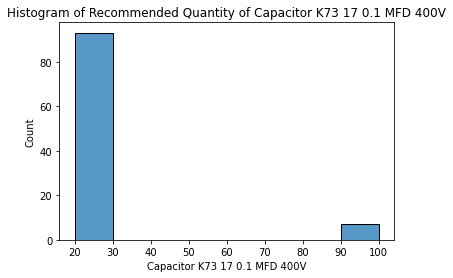

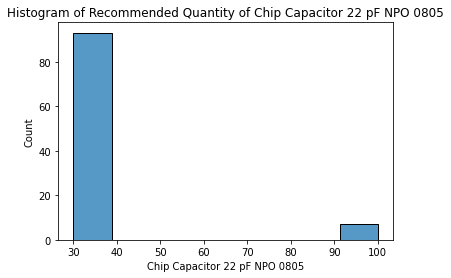

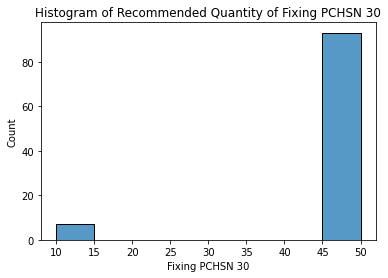

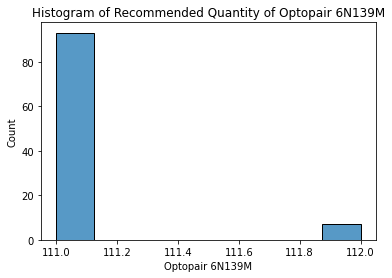

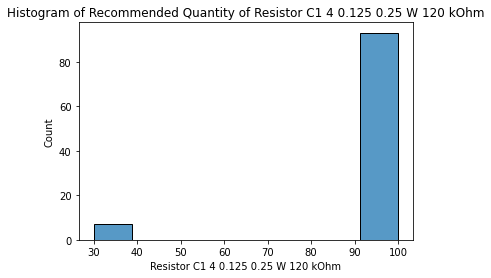

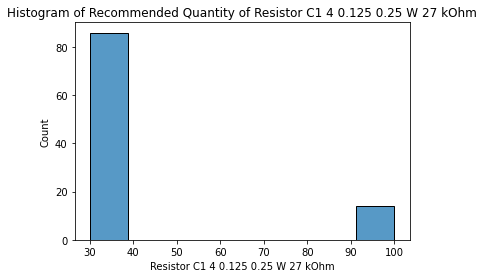

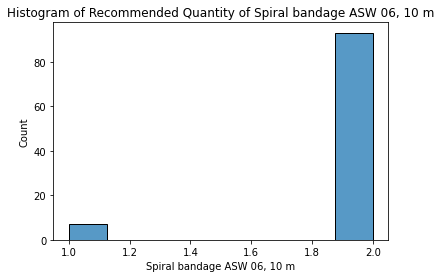

In [84]:
# Plotting histograms of recommended quantities with variance  
for i in simul_result_df_t.index:

    if len(np.unique(simul_result_df[i])) > 1:

        plt.title(f"Histogram of Recommended Quantity of {i}")
        sns.histplot(simul_result_df[i])
        plt.show()

In [85]:
# Choosing the most common values
result_df = simul_result_df.apply(stats.mode).iloc[0, :].astype(int).reset_index()

In [86]:
# Renaming columns 
result_df.rename(columns={"index": "Component/Material", 
                          0: "order_qty"
                         }, 
                 inplace=True)

In [87]:
# Creating an intermediate data frame in order to further joining
df = parts_and_prods[["Component/Material"]]

In [88]:
# Replacing dashes and slashes in names with whitespaces (the function returns names in such a format,
# as a consequence of the specifics of the pulp library)
for i in range(len(df)):
    
    df.loc[i, "Component/Material"] = df.loc[i, "Component/Material"].replace("-", " ")
    
    df.loc[i, "Component/Material"] = df.loc[i, "Component/Material"].replace("/", " ")

In [89]:
# Joining data frames
df = pd.merge(df, result_df, how="left", left_on="Component/Material", right_on="Component/Material").fillna(0)

In [90]:
# Creating a column for recommeded quantities in the main data frame
parts_and_prods["order_qty"] = df["order_qty"].astype(int)

In [91]:
# Determine the prices according to the recommended quantities and discount groups bounds 
for i in range(len(parts_and_prods)):
    
    if parts_and_prods.loc[i, "order_qty"] >= parts_and_prods.loc[i, "Qty 3"]:
        
        parts_and_prods.loc[i, "final_price"] = parts_and_prods.loc[i, "Price 3, RUR"]
        
        
    elif parts_and_prods.loc[i, "order_qty"] >= parts_and_prods.loc[i, "Qty 2"]:
        
        parts_and_prods.loc[i, "final_price"] = parts_and_prods.loc[i, "Price 2, RUR"]
        
        
    else:
        parts_and_prods.loc[i, "final_price"] = parts_and_prods.loc[i, "Price MOQ, RUR"]

In [92]:
# Checking the sum of orders to all suppliers in case of ordering the components and materials 
# in recommended quantities
summa = 0

for i in range(len(parts_and_prods)):
    
    if parts_and_prods.loc[i, "order_qty"] > 0:
        
        summa += parts_and_prods.loc[i, "order_qty"] * parts_and_prods.loc[i, "final_price"] \
                 + parts_and_prods.loc[i, "order_cost"]
        
round(summa, 2)

3180604.09

In [93]:
# Creating the data frame with the final solution
solution = parts_and_prods[["Component/Material", "Supplier", "current_demand", "MOQ", 
                            "Batch", "order_qty"]].round(1)

In [94]:
# Renaming columns before printing on the screen and into the file
solution.rename(columns={"current_demand": "Current Demand", 
                         "order_qty": "Recommended to Order"
                             }, 
                inplace=True)

In [95]:
# Printing the result
solution

,Component/Material,Supplier,Current Demand,MOQ,Batch,Recommended to Order
0,"""Ground"" sign",MPOElmont,17.6,100,100,100
1,"""High Voltage"" sign",MPOElmont,17.6,100,100,100
2,"""Danger"" sign",MPOElmont,-877.4,100,100,0
3,"Spiral bandage ASW-06, 10 m",Platan,0.3,1,1,2
4,Fan DP200A-2123,MicroEM,26.4,20,20,40
5,Fan EC6020L12S,MicroEM,123.7,20,20,140
6,Fan EC8025H12V,MicroEM,20.1,20,20,40
7,Screw M4х12,MIK,54.6,1000,1000,1000
8,Screw M4х20,MIK,17.8,500,500,500
9,Screw M4х45,MIK,69.3,500,500,500


In [96]:
# # Saving the result into the file
# solution.to_excel("solution.xlsx", index=False)

In [97]:
# # To calculate amount and volume without optimization first set N_SIMULATIONS = 1
# # Updating prices in the initial data frame
# parts_and_prods["Price MOQ, RUR"] = simul_df["Price MOQ, RUR"]
# parts_and_prods["Price 2, RUR"] = simul_df["Price 2, RUR"]
# parts_and_prods["Price 3, RUR"] = simul_df["Price 3, RUR"]

# # Quantities to order, prices, sums, and volumes without optimization
# for i, item in enumerate(parts_and_prods["Component/Material"]):
    
#     if parts_and_prods.loc[i, "min_order"] > 0:
        
#         parts_and_prods.loc[i, "qty_wo_opt"] = parts_and_prods.loc[i, "MOQ"]
        
#     else:
#         parts_and_prods.loc[i, "qty_wo_opt"] = 0
        
    
#     while parts_and_prods.loc[i, "min_order"] > parts_and_prods.loc[i, "qty_wo_opt"]:
        
#         parts_and_prods.loc[i, "qty_wo_opt"] += parts_and_prods.loc[i, "Batch"]
        
        
#     if parts_and_prods.loc[i, "qty_wo_opt"] >= parts_and_prods.loc[i, "Qty 3"]:
        
#         parts_and_prods.loc[i, "price_wo_opt"] = parts_and_prods.loc[i, "Price 3, RUR"]
        
#     elif parts_and_prods.loc[i, "qty_wo_opt"] >= parts_and_prods.loc[i, "Qty 2"]:
        
#         parts_and_prods.loc[i, "price_wo_opt"] = parts_and_prods.loc[i, "Price 2, RUR"]
        
#     else:
#         parts_and_prods.loc[i, "price_wo_opt"] = parts_and_prods.loc[i, "Price MOQ, RUR"]
        
        
#     parts_and_prods.loc[i, "sum_wo_opt"] = round(parts_and_prods.loc[i, "qty_wo_opt"] \
#                                                  * parts_and_prods.loc[i, "price_wo_opt"] \
#                                                  + parts_and_prods.loc[i, "order_cost"], 2)
    
    
#     parts_and_prods.loc[i, "vol_wo_opt"] = round(parts_and_prods.loc[i, "qty_wo_opt"] \
#                                                  * parts_and_prods.loc[i, "Space in warehouse"])

# # Total amount without optimization
# parts_and_prods["sum_wo_opt"].sum().round(2)

# # Total volume without optimization
# parts_and_prods["vol_wo_opt"].sum().round(2)